# Orientation Selectivity

In [1]:
import sys, os
import numpy as np
import scipy

# physion should be installed with "pip install physion"
import physion
import physion.utils.plot_tools as pt
import matplotlib.pylab as plt

import warnings
warnings.filterwarnings("ignore") # disable the UserWarning from pynwb (arrays are not well oriented)

# data folder:
DATA_folder = os.path.join(os.path.expanduser('~'), 'DATA/CIBELE/PV_dendrites_V1/test2024/Assembled/SOMAS/8orient_2contr')

In [2]:
DATASET = physion.analysis.read_NWB.scan_folder_for_NWBfiles(DATA_folder, verbose=False)

In [3]:
for i, f in enumerate(DATASET['files']):
    print('- sessionID %.2d : %s' % (i, os.path.basename(f)))

- sessionID 00 : 2024_03_22-15-00-16.nwb
- sessionID 01 : 2024_04_15-15-28-30.nwb
- sessionID 02 : 2024_04_24-15-14-45.nwb
- sessionID 03 : 2024_04_24-16-12-11.nwb
- sessionID 04 : 2024_04_24-17-18-05.nwb
- sessionID 05 : 2024_04_29-15-10-12.nwb
- sessionID 06 : 2024_04_29-16-00-56.nwb
- sessionID 07 : 2024_05_06-10-52-15.nwb
- sessionID 08 : 2024_05_06-17-22-56.nwb


# Computing Average Responses over All ROIs

In [4]:
Nmax = 10000


##################################################
########### PARAMETERS OF THE ANALYSIS ###########
##################################################
INTERVALS = {'pre':[-1.5,0.], 'post':[0.,1.5]}

significance_threshold = 0.05 # for the evoked response shift (with respect to baseline)
test_for_significance = 'ttest' # type of statistical test used, either: ttest, wilcoxon, anova
##################################################

Ncontrast, Norientation = 2, 8

DATASET['nSessions'] = len(DATASET['files'][:Nmax])

DATASET['nROIs'] = []

##################################
##### Initialize Responses #######
##################################

for f, filename in enumerate(DATASET['files'][:Nmax]):
    for c in range(Ncontrast):
        for o in range(Norientation):
            DATASET['session%i-contrast%i-orientation%i' % (f,c,o)] = {
                                                                'resp':[],
                                                                'significant-positive-ROIS':[],
                                                                'significant-negative-ROIS':[],
                                                                'deflect-positive-ROIS':[],
                                                                'deflect-negative-ROIS':[]
            }


for f, filename in enumerate(DATASET['files'][:Nmax]):

    data = physion.analysis.read_NWB.Data(filename,
                                          verbose=False)
    data.build_dFoF(verbose=False)
    DATASET['nROIs'].append(data.nROIs)

    ########################################################
    #######.   stimulus-evoked activity        #############
    ########################################################

    episodes = physion.analysis.process_NWB.EpisodeData(data, 
                                                        quantities=['dFoF'],
                                                        prestim_duration=3.,
                                                        protocol_id=0,
                                                        verbose=False)


    contrasts = np.unique(episodes.contrast)
    orientations = np.unique(episodes.angle)
    
    # loop over contrast levels
    for c, contrast in enumerate(contrasts):
        # loop over orientations levels
        for o, orientation in enumerate(orientations):
            
            cond = (episodes.angle==orientation) &\
                        (episodes.contrast==contrast)

            # loop over ROIs
            for roi in range(episodes.dFoF.shape[1]):

                dFoF = np.mean(episodes.dFoF[cond,roi,:], axis=0)
                
                DATASET['session%i-contrast%i-orientation%i' % (f,c,o)]['resp'].append(\
                                        dFoF-np.mean(dFoF[(episodes.t>-0.5) & (episodes.t<0)]))

                stats = episodes.stat_test_for_evoked_responses(response_args={'roiIndex':roi},
                                                                episode_cond=cond,
                                                                interval_pre=INTERVALS['pre'],
                                                                interval_post=INTERVALS['post'],
                                                                test=test_for_significance,
                                                                positive=True,
                                                                verbose=True)
                deflect = np.mean(stats.y-stats.x)
                if (stats.pvalue<significance_threshold) and (deflect>0):
                    DATASET['session%i-contrast%i-orientation%i' % (f,c,o)]['significant-positive-ROIS'].append(roi)
                    DATASET['session%i-contrast%i-orientation%i' % (f,c,o)]['deflect-positive-ROIS'].append(deflect)
                elif (stats.pvalue<significance_threshold):
                    # negative deflect
                    DATASET['session%i-contrast%i-orientation%i' % (f,c,o)]['significant-negative-ROIS'].append(roi)
                    DATASET['session%i-contrast%i-orientation%i' % (f,c,o)]['deflect-negative-ROIS'].append(deflect)

DATASET['contrasts'] = contrasts
DATASET['orientations'] = orientations
DATASET['t'] = episodes.t

## Plot Stimulus-Evoked activity average across all cells (Grand-Average)

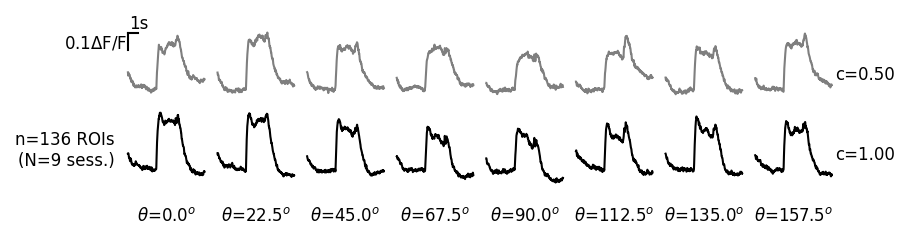

In [5]:
fig, AX = pt.figure(axes=(len(orientations),len(contrasts)), figsize=(.8,.8),wspace=0.1,hspace=0.1)

COLORS = ['tab:grey', 'k']


for c, contrast in enumerate(DATASET['contrasts']):
    
    for o, orientation in enumerate(DATASET['orientations']):

        allResps = np.concatenate([DATASET['session%i-contrast%i-orientation%i' % (f,c,o)]['resp']\
                                   for f in range(DATASET['nSessions'])])
        pt.plot(DATASET['t'], 
                np.mean(allResps, axis=0), 
                #sy=np.std(allResps, axis=0),
                #sy=scipy.stats.sem(allResps, axis=0),
                color=COLORS[c], ax=AX[c][o])
        
        AX[c][o].axis('off')
        
pt.annotate(AX[-1][0], '   \nn=%i ROIs \n(N=%i sess.) ' % (np.sum(DATASET['nROIs']),
                                                          DATASET['nSessions']),
           (-0.05,1), va='top', ha='right', color=COLORS[c])
    
for c, contrast in enumerate(DATASET['contrasts']):
    pt.annotate(AX[c][-1], '\nc=%.2f' % contrast, (1,0.8), va='top')
for o, orientation in enumerate(DATASET['orientations']):
    pt.annotate(AX[-1][o], '\n$\\theta$=%.1f$^o$' % orientation, (0.5,0.), va='top', ha='center')
        
pt.set_common_ylims(AX)
pt.draw_bar_scales(AX[0][0], Xbar=1, Xbar_label='1s', Ybar=0.1, Ybar_label='0.1$\Delta$F/F')

#fig.savefig(os.path.expanduser('~'), 'Desktop', 'fig.svg')

## Functions to evaluate Orientation Selectivity

In [6]:
stat_test_props = dict(interval_pre=[-1.,0],                                   
                       interval_post=[1.,2.],                                   
                       test='ttest',                                            
                       positive=True)
response_significance_threshold = 0.05

def orientation_selectivity_index(resp_pref, resp_90):
    """                                                                         
     computes the selectivity index: (Pref-Orth)/Pref
     clipped in [0,1] --> because resp_90 can be negative    
    """
    return (resp_pref-np.clip(resp_90, 0, np.inf))/resp_pref


def shift_orientation_according_to_pref(angle,
                                        pref_angle=0,
                                        start_angle=-45,
                                        angle_range=360):
    new_angle = (angle-pref_angle)%angle_range
    if new_angle>=angle_range+start_angle:
        return new_angle-angle_range
    else:
        return new_angle


def compute_tuning_response_per_cells(data,
                                      imaging_quantity='dFoF',
                                      prestim_duration=None,
                                      stat_test_props=stat_test_props,
                                      response_significance_threshold = response_significance_threshold,
                                      contrast=1,
                                      protocol_name='ff-gratings-8orientation-2contrasts-10repeats',
                                      return_significant_waveforms=False,
                                      verbose=True):

    RESPONSES = []

    protocol_id = data.get_protocol_id(protocol_name=protocol_name)

    EPISODES = physion.analysis.process_NWB.EpisodeData(data,
                           quantities=[imaging_quantity],
                           protocol_id=protocol_id,
                           prestim_duration=prestim_duration,
                           verbose=verbose)

    shifted_angle = EPISODES.varied_parameters['angle']-\
                            EPISODES.varied_parameters['angle'][1]

    significant_waveforms= []
    significant = np.zeros(data.nROIs, dtype=bool)

    for roi in np.arange(data.nROIs):

        cell_resp = EPISODES.compute_summary_data(stat_test_props,
                        response_significance_threshold=response_significance_threshold,
                        response_args=dict(quantity=imaging_quantity, roiIndex=roi))

        condition = (cell_resp['contrast']==contrast)

        # if significant in at least one orientation
        if np.sum(cell_resp['significant'][condition]):

            significant[roi] = True

            ipref = np.argmax(cell_resp['value'][condition])
            prefered_angle = cell_resp['angle'][condition][ipref]

            RESPONSES.append(np.zeros(len(shifted_angle)))

            for angle, value in zip(cell_resp['angle'][condition],
                                    cell_resp['value'][condition]):

                new_angle = shift_orientation_according_to_pref(angle,
                                                                pref_angle=prefered_angle,
                                                                start_angle=-22.5,
                                                                angle_range=180)
                iangle = np.flatnonzero(shifted_angle==new_angle)[0]

                RESPONSES[-1][iangle] = value

            if return_significant_waveforms:
                full_cond = EPISODES.find_episode_cond(\
                        key=['contrast', 'angle'],
                        value=[contrast, prefered_angle])
                significant_waveforms.append(getattr(EPISODES, imaging_quantity)[full_cond,roi,:].mean(axis=0))

    if return_significant_waveforms:
        return EPISODES.t, significant_waveforms
    else:
        return RESPONSES, significant, shifted_angle

In [7]:

def compute_summary_responses(DATASET,
                              quantity='dFoF',
                              roi_to_neuropil_fluo_inclusion_factor=1.15,
                              neuropil_correction_factor = 0.7,
                              method_for_F0 = 'sliding_percentile',
                              percentile=5., # percent
                              sliding_window = 300, # seconds
                              Nmax=999, # max datafiles (for debugging)
                              stat_test_props=dict(interval_pre=[-1.,0],                                   
                                                   interval_post=[1.,2.],                                   
                                                   test='anova',                                            
                                                   positive=True),
                              response_significance_threshold=5e-2,
                              verbose=True):
    
    SUMMARY = {}
    
    SUMMARY['quantity'] = quantity
    SUMMARY['quantity_args'] = dict(roi_to_neuropil_fluo_inclusion_factor=\
                                        roi_to_neuropil_fluo_inclusion_factor,
                                    method_for_F0=method_for_F0,
                                    percentile=percentile,
                                    sliding_window=sliding_window,
                                    neuropil_correction_factor=neuropil_correction_factor)
    


    for c, contrast in enumerate(DATASET['contrasts']):
        SUMMARY['contrast%i'%c] = {'RESPONSES':[], 'OSI':[], 'FRAC_RESP':[]}
        
    for f in DATASET['files'][:Nmax]:

        print('analyzing "%s" [...] ' % f)
        data = physion.analysis.read_NWB.Data(f, verbose=False)

        if quantity=='dFoF':
            data.build_dFoF(roi_to_neuropil_fluo_inclusion_factor=\
                                    roi_to_neuropil_fluo_inclusion_factor,
                            method_for_F0=method_for_F0,
                            percentile=percentile,
                            sliding_window=sliding_window,
                            neuropil_correction_factor=neuropil_correction_factor,
                            verbose=False)

        elif quantity=='rawFluo':
            data.build_rawFluo(verbose=verbose)
        elif quantity=='neuropil':
            data.build_neuropil(verbose=verbose)            
        else:
            print('quantity not recognized !!')

        protocol = 'ff-gratings-8orientation-2contrasts-15repeats'
        
        for c, contrast in enumerate(DATASET['contrasts']):

            # at full contrast
            responses, frac_resp, shifted_angle = compute_tuning_response_per_cells(data,
                                                                                    imaging_quantity=quantity,
                                                                                    contrast=contrast,
                                                                                    protocol_name=protocol,
                                                                                    stat_test_props=stat_test_props,
                                                                                    response_significance_threshold=response_significance_threshold,
                                                                                    verbose=False)

            SUMMARY['contrast%i'%c]['RESPONSES'].append(responses)
            SUMMARY['contrast%i'%c]['OSI'].append([orientation_selectivity_index(r[1], r[5]) for r in responses])
            SUMMARY['contrast%i'%c]['FRAC_RESP'].append(frac_resp)

    SUMMARY['shifted_angle'] = shifted_angle
    
    return SUMMARY

In [8]:
SUMMARY = compute_summary_responses(DATASET)

analyzing "/home/yann.zerlaut/DATA/CIBELE/PV_dendrites_V1/test2024/Assembled/SOMAS/8orient_2contr/2024_03_22-15-00-16.nwb" [...] 
analyzing "/home/yann.zerlaut/DATA/CIBELE/PV_dendrites_V1/test2024/Assembled/SOMAS/8orient_2contr/2024_04_15-15-28-30.nwb" [...] 
analyzing "/home/yann.zerlaut/DATA/CIBELE/PV_dendrites_V1/test2024/Assembled/SOMAS/8orient_2contr/2024_04_24-15-14-45.nwb" [...] 
analyzing "/home/yann.zerlaut/DATA/CIBELE/PV_dendrites_V1/test2024/Assembled/SOMAS/8orient_2contr/2024_04_24-16-12-11.nwb" [...] 
analyzing "/home/yann.zerlaut/DATA/CIBELE/PV_dendrites_V1/test2024/Assembled/SOMAS/8orient_2contr/2024_04_24-17-18-05.nwb" [...] 
analyzing "/home/yann.zerlaut/DATA/CIBELE/PV_dendrites_V1/test2024/Assembled/SOMAS/8orient_2contr/2024_04_29-15-10-12.nwb" [...] 
analyzing "/home/yann.zerlaut/DATA/CIBELE/PV_dendrites_V1/test2024/Assembled/SOMAS/8orient_2contr/2024_04_29-16-00-56.nwb" [...] 
analyzing "/home/yann.zerlaut/DATA/CIBELE/PV_dendrites_V1/test2024/Assembled/SOMAS/8orient

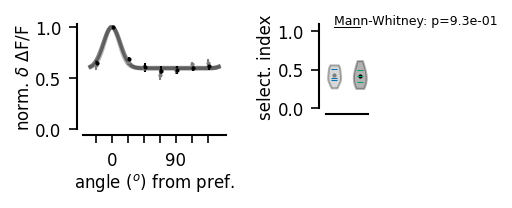

In [9]:
from scipy.optimize import minimize
import matplotlib.pylab as plt

def func(S, X):
    """ fitting function """
    nS = (S+90)%180-90
    return X[0]*np.exp(-(nS**2/2./X[1]**2))+X[2]

def selectivity_index(resp1, resp2):
    return (resp1-np.clip(resp2, 0, np.inf))/resp1

def generate_comparison_figs(SUMMARY, 
                             cases=['WT'],
                             average_by='ROIs',
                             colors=['tab:grey', 'k'],
                             norm='',
                             ms=1):
    
    fig, ax = plt.subplots(1, figsize=(2, 1))
    plt.subplots_adjust(top=0.9, bottom=0.2, right=0.6)
    inset = pt.inset(ax, (1.7, 0.2, 0.3, 0.8))

    SIs = []
    for i, key in enumerate(cases):

        if average_by=='sessions':
            resp = np.array([np.mean(r, axis=0) for r in SUMMARY[key]['RESPONSES']])
        else:
            resp = np.concatenate([r for r in SUMMARY[key]['RESPONSES']])
        resp = np.clip(resp, 0, np.inf) # CLIP RESPONSIVE TO POSITIVE VALUES
        
        if norm!='':
            resp = np.divide(resp, np.max(resp, axis=1, keepdims=True))
            
        SIs.append([selectivity_index(r[1], r[5]) for r in resp])

        # data
        pt.scatter(SUMMARY['shifted_angle']+2*i, np.mean(resp, axis=0),
                   sy=scipy.stats.sem(resp, axis=0), ax=ax, color=colors[i], ms=ms)
        
        # fit
        def to_minimize(x0):
            return np.sum((resp.mean(axis=0)-\
                           func(SUMMARY['shifted_angle'], x0))**2)
        
        res = minimize(to_minimize,
                       [0.8, 10, 0.2])
        x = np.linspace(-30, 180-30, 100)
        ax.plot(x, func(x, res.x), lw=2, alpha=.5, color=colors[i])

        try:
            if average_by=='sessions':
                inset.annotate(i*'\n'+'\nN=%i %s (%i ROIs, %i mice)' % (len(resp),
                                                    average_by, np.sum([len(r) for r in SUMMARY[key]['RESPONSES']]),
                                                    len(np.unique(SUMMARY[key]['subjects']))),
                               (0,0), fontsize=7,
                               va='top',color=colors[i], xycoords='axes fraction')
            else:
                inset.annotate(i*'\n'+'\nn=%i %s (%i sessions, %i mice)' % (len(resp),
                                                    average_by, len(SUMMARY[key]['RESPONSES']),
                                                                    len(np.unique(SUMMARY[key]['subjects']))),
                               (0,0), fontsize=7,
                               va='top',color=colors[i], xycoords='axes fraction')
        except BaseException as be:
            pass
            
        
    # selectivity index
    for i, key in enumerate(cases):
        pt.violin(SIs[i], x=i, ax=inset, color=colors[i])
    if len(cases)==2:
        inset.plot([0,1], 1.05*np.ones(2), 'k-', lw=0.5)
        inset.annotate('Mann-Whitney: p=%.1e' % scipy.stats.mannwhitneyu(SIs[0], SIs[1]).pvalue,
                       (0, 1.09), fontsize=6)
    pt.set_plot(inset, xticks=[], ylabel='select. index', yticks=[0, 0.5, 1], ylim=[0, 1.09])

    ylabel=norm+'$\delta$ %s' % SUMMARY['quantity'].replace('dFoF', '$\Delta$F/F')
    pt.set_plot(ax, xlabel='angle ($^o$) from pref.',
                ylabel=ylabel,
                yticks=[0.,0.5,1],
                xticks=SUMMARY['shifted_angle'],
                xticks_labels=['%.0f'%s if (i%4==1) else '' for i,s in enumerate(SUMMARY['shifted_angle'])])

    return fig, ax

fig, ax = generate_comparison_figs(SUMMARY, ['contrast0', 'contrast1'], average_by='sessions', norm='norm. ')
#fig.savefig(os.path.join(os.path.expanduser('~'), 'Desktop', 'fig.svg')

## Show Example ROIs responses

In [10]:
from physion.dataviz.episodes.trial_average import plot as plot_trial_average


def selectivity_index(angles, resp):
    """
    computes the selectivity index: (Pref-Orth)/(Pref+Orth)
    clipped in [0,1]
    """
    imax = np.argmax(resp)
    iop = np.argmin(((angles[imax]+90)%(180)-angles)**2)
    if (resp[imax]>0):
        return min([1,max([0,(resp[imax]-resp[iop])/(resp[imax]+resp[iop])])])
    else:
        return 0

def cell_tuning_example_fig(filename,
                            contrast=1.0,
                            stat_test_props = dict(interval_pre=[-1,0], 
                                                   interval_post=[1,2],
                                                   test='ttest',
                                                   positive=True),
                            response_significance_threshold = 0.01,
                            Nsamples = 10, # how many cells we show
                            seed=10):
    
    np.random.seed(seed)
    
    data = physion.analysis.read_NWB.Data(filename)
    
    EPISODES = physion.analysis.process_NWB.EpisodeData(data,
                           quantities=['dFoF'],
                           protocol_id=np.flatnonzero(['8orientation' in p for p in data.protocols]),
                           with_visual_stim=True,
                           verbose=True)
    
    fig, AX = pt.plt.subplots(Nsamples, len(EPISODES.varied_parameters['angle']), 
                          figsize=(7,7))
    plt.subplots_adjust(right=0.75, left=0.1, top=0.97, bottom=0.05, wspace=0.1, hspace=0.8)
    
    for Ax in AX:
        for ax in Ax:
            ax.axis('off')

    for i, r in enumerate(np.random.choice(np.arange(data.nROIs), 
                                           min([Nsamples, data.nROIs]), replace=False)):

        # SHOW trial-average
        plot_trial_average(EPISODES,
                           condition=(EPISODES.contrast==contrast),
                           column_key='angle',
                           #color_key='contrast',
                           #color=['lightgrey', 'k'],
                           quantity='dFoF',
                           Ybar=1., Ybar_label='1dF/F',
                           Xbar=1., Xbar_label='1s',
                           roiIndex=r,
                           with_stat_test=True,
                           stat_test_props=stat_test_props,
                           with_screen_inset=True,
                           AX=[AX[i]], no_set=False)
        AX[i][0].annotate('roi #%i  ' % (r+1), (0,0), ha='right', xycoords='axes fraction')

        # SHOW summary angle dependence
        inset = pt.inset(AX[i][-1], (2.2, 0.2, 1.2, 0.8))

        angles, y, sy, responsive_angles = [], [], [], []
        responsive = False

        for a, angle in enumerate(EPISODES.varied_parameters['angle']):

            stats = EPISODES.stat_test_for_evoked_responses(episode_cond=\
                                            EPISODES.find_episode_cond(key=['angle', 'contrast'],
                                                                       value=[angle, contrast]),
                                                            response_args=dict(quantity='dFoF', roiIndex=r),
                                                            **stat_test_props)

            angles.append(angle)
            y.append(np.mean(stats.y-stats.x))    # means "post-pre"
            sy.append(np.std(stats.y-stats.x))    # std "post-pre"

            if stats.significant(threshold=response_significance_threshold):
                responsive = True
                responsive_angles.append(angle)

        pt.plot(angles, np.array(y), sy=np.array(sy), ax=inset)
        inset.plot(angles, 0*np.array(angles), 'k:', lw=0.5)
        inset.set_ylabel('$\delta$ $\Delta$F/F     ', fontsize=7)
        inset.set_xticks(angles)
        inset.set_xticklabels(['%i'%a if (i%2==0) else '' for i, a in enumerate(angles)], fontsize=7)
        if i==(Nsamples-1):
            inset.set_xlabel('angle ($^{o}$)', fontsize=7)

        SI = selectivity_index(angles, y)
        inset.annotate('SI=%.2f ' % SI, (1, 1), ha='right', style='italic', fontsize=6,
                       color=('k' if responsive else 'lightgray'), xycoords='axes fraction')
        
    return fig

NWB-file reading time: 398.4ms
  Number of episodes over the whole recording: 240/240 (with protocol condition)
  building episodes with 1 modalities [...]

calculating dF/F with method "percentile" [...]

  ** all ROIs passed the positive F0 criterion ** 

-> dFoF calculus done !  (calculation took 0.0s)
  -> [ok] episodes ready !


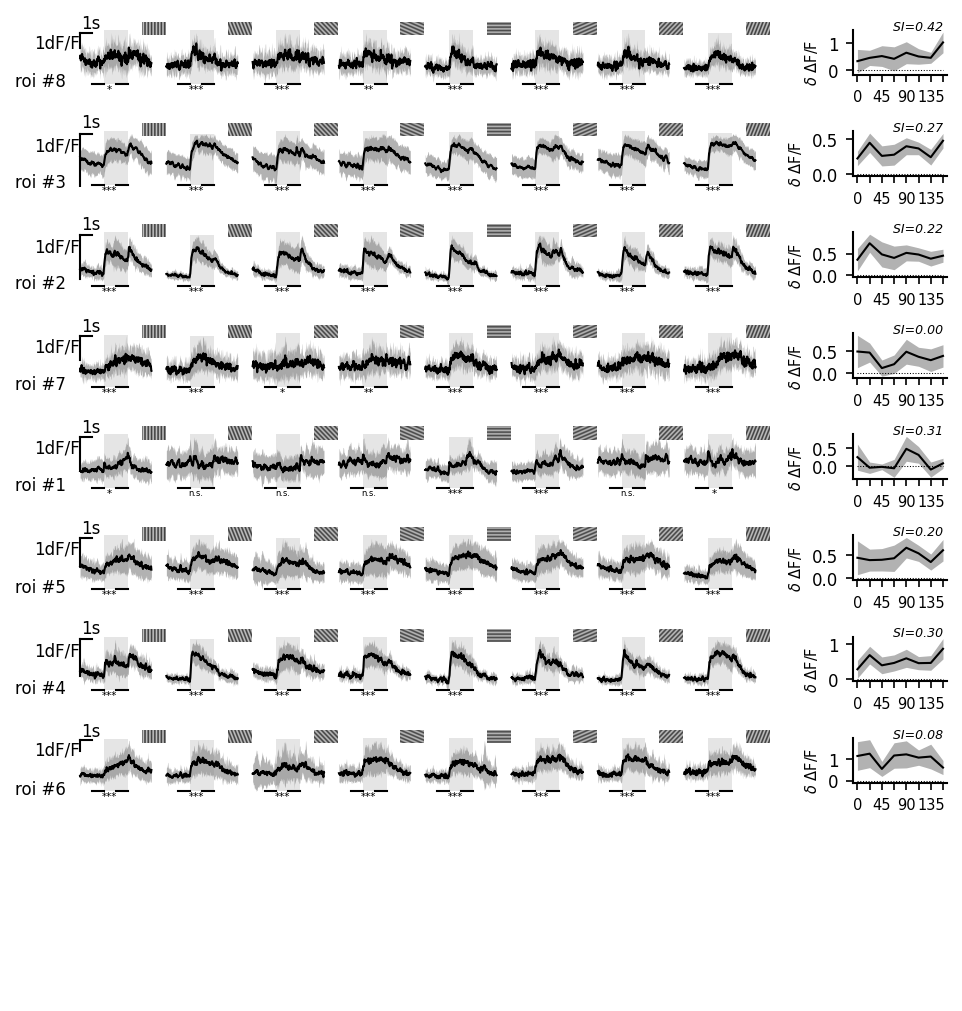

In [11]:
fig = cell_tuning_example_fig(DATASET['files'][1], contrast=0.5)
#fig.savefig(os.path.join(os.path.expanduser('~'), 'Desktop', 'fig.svg')